In [464]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [465]:
%matplotlib inline

from matplotlib import image as mpimage
from matplotlib import pyplot as plt

import yaml
import os

import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split

In [522]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs

In [523]:
SEED = 1993

In [524]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

In [525]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
patches_files = [os.path.join(patches_path, x) for x in os.listdir(patches_path)]

In [521]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')

## Train/Test split in Slides

The idea is to avoid using patches from the same slide both in train and test.

In [470]:
slides_df = slides_df[slides_df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

In [471]:
slides_df['sample_type'].value_counts(normalize=True)

Primary Tumor          0.907527
Solid Tissue Normal    0.092473
Name: sample_type, dtype: float64

In [472]:
slides_train, slides_test = train_test_split(slides_df, test_size=0.2, 
                                             stratify=slides_df['sample_type'], random_state=SEED) 

In [473]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

In [474]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

## Read Images

In [475]:
patches_files_train = [x for x in patches_files 
                       if any([y in x for y in slides_train['slide_id'].values])]

In [476]:
patches_files_train = patches_files_train[:1000]

In [477]:
images_train = np.array([mpimage.imread(x) for x in patches_files_train])

In [462]:
images_train.shape

(1000, 128, 128, 3)

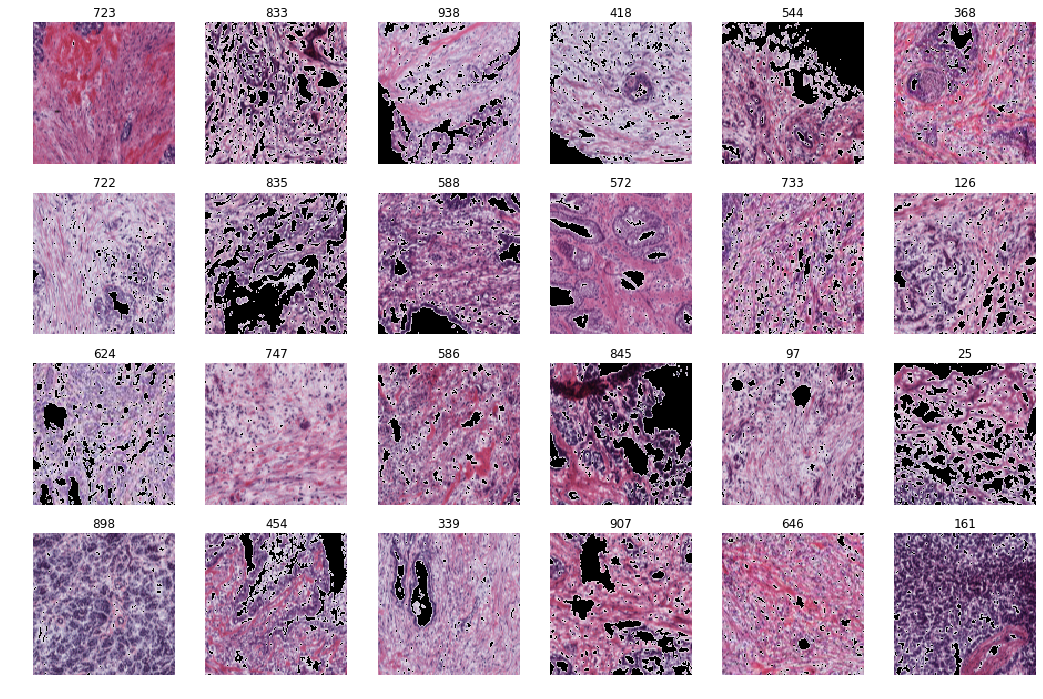

In [537]:
plot_sample_imgs(images_train, n_rows=4, n_cols=6)

In [534]:
import tensorflow as tf

In [535]:
with tf.Session() as sess:
    devices = sess.list_devices()


from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12886671880132777577
]
